<a href="https://colab.research.google.com/github/glomanu/TMDLGroupProject/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files

uploaded_files = files.upload()
#create the dataframe
dfs = []
#read files


Saving checkpoint_final_data.xlsx to checkpoint_final_data (1).xlsx


In [ ]:
for file_name in uploaded_files.keys():
    df = pd.read_csv(file_name)
    dfs.append(df)
#merge files
merged_df = pd.concat(dfs)


In [ ]:
merged_df["Month"] = pd.to_datetime(merged_df["Month"], format="%Y-%m")

#Get only obs for NYSE(N), month and notional value
nyse_n_df = merged_df.loc[
    merged_df["Market Participant"] == "NYSE (N)",
    ["Market Participant", "Month", "Total Notional"]
]

# Drop duplicates, i was getting an error with duplicates for month
nyse_n_df = nyse_n_df.drop_duplicates(subset="Month")

#Romove obs with no data for month or total notional data
nyse_n_df = nyse_n_df.dropna(subset=["Month"])
nyse_n_df = nyse_n_df[nyse_n_df["Total Notional"] != 0]


print(nyse_n_df.head())
print(nyse_n_df.tail())

   Market Participant      Month  Total Notional
12           NYSE (N) 2011-01-01    6.497868e+11
27           NYSE (N) 2011-02-01    6.105946e+11
42           NYSE (N) 2011-03-01    7.527405e+11
57           NYSE (N) 2011-04-01    5.791401e+11
72           NYSE (N) 2011-05-01    6.776794e+11
   Market Participant      Month  Total Notional
14           NYSE (N) 2023-01-01    9.782948e+11
33           NYSE (N) 2023-02-01    9.939717e+11
52           NYSE (N) 2023-03-01    1.415257e+12
71           NYSE (N) 2023-04-01    9.003488e+11
90           NYSE (N) 2023-05-01    1.133465e+12


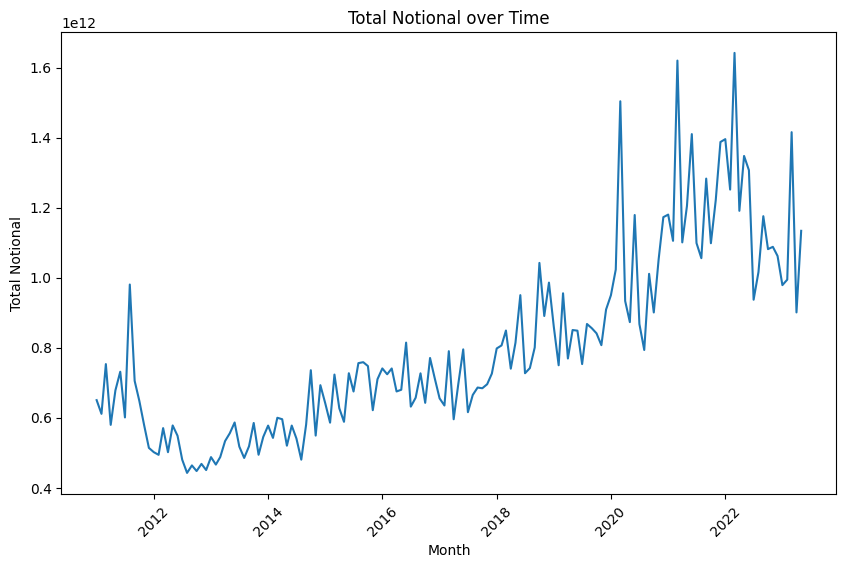

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nyse_n_df["Month"], nyse_n_df["Total Notional"])
plt.title("Total Notional over Time")
plt.xlabel("Month")
plt.ylabel("Total Notional")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Saving data
nyse_n_df.to_excel("nyse_n_data.xlsx", index=False)
files.download("/content/nyse_n_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Apply Dickey-Fuller test for non-stationarity
from statsmodels.tsa.stattools import adfuller

notional_values = nyse_n_df["Total Notional"]

result = adfuller(notional_values)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

Dickey-Fuller Test Results:
ADF Statistic: -0.8474871142475856
p-value: 0.8047737462208093
Critical Values:
1%: -3.4793722137854926
5%: -2.8830370378332995
10%: -2.578233635380623


In [ ]:
#Notional value is non-stationary. So, we will put in growth rates.
#put it in monthly order
nyse_n_df = nyse_n_df.sort_values("Month")

nyse_n_df["Monthly Growth"] = nyse_n_df["Total Notional"].pct_change()

print(nyse_n_df.head())

   Market Participant      Month  Total Notional  Monthly Growth
12           NYSE (N) 2011-01-01    6.497868e+11             NaN
27           NYSE (N) 2011-02-01    6.105946e+11       -0.060316
42           NYSE (N) 2011-03-01    7.527405e+11        0.232799
57           NYSE (N) 2011-04-01    5.791401e+11       -0.230625
72           NYSE (N) 2011-05-01    6.776794e+11        0.170148


In [ ]:
#Droping the first obs, as it was NaN due to the change to Monthly growth
nyse_n_df = nyse_n_df.dropna(subset=["Monthly Growth"], how="any")

# Rename
nyse_n_df = nyse_n_df.rename(columns={"Monthly Growth": "Monthly Growth Dollar Value Traded", "Total Notional": "Dollar Value Traded"})

# Print the updated dataframe
print(nyse_n_df.head())

   Market Participant      Month  Dollar Value Traded  \
27           NYSE (N) 2011-02-01         6.105946e+11   
42           NYSE (N) 2011-03-01         7.527405e+11   
57           NYSE (N) 2011-04-01         5.791401e+11   
72           NYSE (N) 2011-05-01         6.776794e+11   
87           NYSE (N) 2011-06-01         7.309292e+11   

    Monthly Growth Dollar Value Traded  
27                           -0.060316  
42                            0.232799  
57                           -0.230625  
72                            0.170148  
87                            0.078577  


Dickey-Fuller Test Results:
ADF Statistic: -2.9142371442671826
p-value: 0.043717283731658285
Critical Values:
1%: -3.4793722137854926
5%: -2.8830370378332995
10%: -2.578233635380623


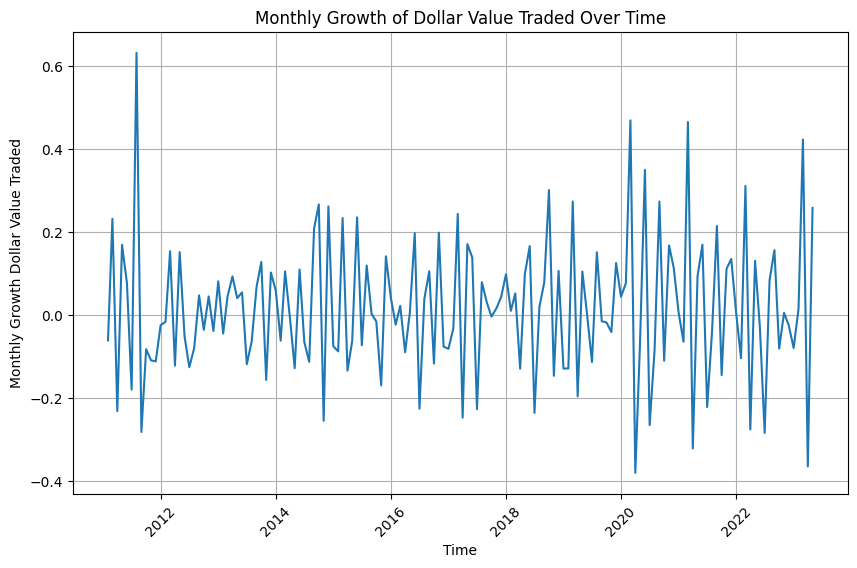

In [ ]:

#Perform the Dickey-Fuller test to check if Monthly Growth Dollar Value Traded is still non-stationary
monthly_growth = nyse_n_df["Monthly Growth Dollar Value Traded"]

result = adfuller(monthly_growth)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

#And plot it

plt.figure(figsize=(10, 6))
plt.plot(nyse_n_df["Month"], nyse_n_df["Monthly Growth Dollar Value Traded"])
plt.xlabel("Time")
plt.ylabel("Monthly Growth Dollar Value Traded")
plt.title("Monthly Growth of Dollar Value Traded Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Monthly Growth Dollar Value Traded is non-stationary and will be used for the rest of the analysis.

In [ ]:
#Re-download this updated dateset
nyse_n_df.to_excel("nyse_n_data.xlsx", index=False)
files.download("/content/nyse_n_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Fixing inflation file
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files
nyse_n_df = pd.read_excel("nyse_inflation.xlsx")
print(nyse_n_df)

    Market Participant      Month  Dollar Value Traded  \
0             NYSE (N) 2011-02-01         6.105946e+11   
1             NYSE (N) 2011-03-01         7.527405e+11   
2             NYSE (N) 2011-04-01         5.791401e+11   
3             NYSE (N) 2011-05-01         6.776794e+11   
4             NYSE (N) 2011-06-01         7.309292e+11   
..                 ...        ...                  ...   
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Monthly Growth Dollar Value Traded  
0                             -0.060316  
1                              0.232799  
2                             -0.230625  
3                              0.170148  
4                              0.078577  
..                                  ...  
143      

In [ ]:
#Load inflation data
#I already had to make this data more readable in excel before importing

file_path = '/content/Inflation modified.xlsx'
inflation_data = pd.read_excel(file_path)
print(inflation_data.head())

       Month  Inflation
0 2013-01-01        1.9
1 2013-02-01        2.0
2 2013-03-01        1.9
3 2013-04-01        1.7
4 2013-05-01        1.7


In [ ]:
#merge
nyse_inflation = pd.merge(nyse_n_df, inflation_data, on="Month", how="left")
print(nyse_inflation.head())
print(nyse_inflation.tail())

  Market Participant      Month  Dollar Value Traded  \
0           NYSE (N) 2011-02-01         6.105946e+11   
1           NYSE (N) 2011-03-01         7.527405e+11   
2           NYSE (N) 2011-04-01         5.791401e+11   
3           NYSE (N) 2011-05-01         6.776794e+11   
4           NYSE (N) 2011-06-01         7.309292e+11   

   Monthly Growth Dollar Value Traded  Inflation  
0                           -0.060316        NaN  
1                            0.232799        NaN  
2                           -0.230625        NaN  
3                            0.170148        NaN  
4                            0.078577        NaN  
    Market Participant      Month  Dollar Value Traded  \
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Mon

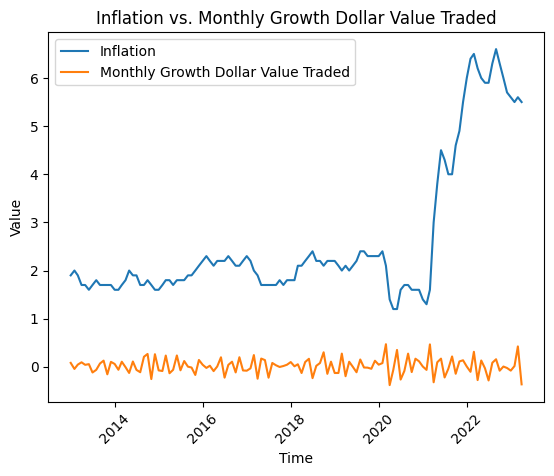

In [ ]:

# taking off observations with no data for inflation
filtered_data = nyse_inflation.dropna(subset=["Inflation"])
#plot
plt.plot(filtered_data["Month"], filtered_data["Inflation"], label="Inflation")
plt.plot(filtered_data["Month"], filtered_data["Monthly Growth Dollar Value Traded"], label="Monthly Growth Dollar Value Traded")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Inflation vs. Monthly Growth Dollar Value Traded")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Save and download the data
nyse_inflation.to_excel("nyse_inflation_final.xlsx", index=False)
files.download("/content/nyse_inflation_final.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#loggin on to the dataset again, so we don't have to re-run everything
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files
nyse_inflation = pd.read_excel("nyse_inflation_final.xlsx")
print(nyse_inflation)

    Market Participant      Month  Dollar Value Traded  \
0             NYSE (N) 2011-02-01         6.105946e+11   
1             NYSE (N) 2011-03-01         7.527405e+11   
2             NYSE (N) 2011-04-01         5.791401e+11   
3             NYSE (N) 2011-05-01         6.776794e+11   
4             NYSE (N) 2011-06-01         7.309292e+11   
..                 ...        ...                  ...   
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Monthly Growth Dollar Value Traded  Inflation  
0                             -0.060316        NaN  
1                              0.232799        NaN  
2                             -0.230625        NaN  
3                              0.170148        NaN  
4                              0.07857

0      -6.031550
1      23.279927
2     -23.062452
3      17.014765
4       7.857667
         ...    
143    -7.850232
144     1.602481
145    42.383994
146   -36.382647
147    25.891780
Name: Monthly Growth Dollar Value Traded, Length: 148, dtype: float64


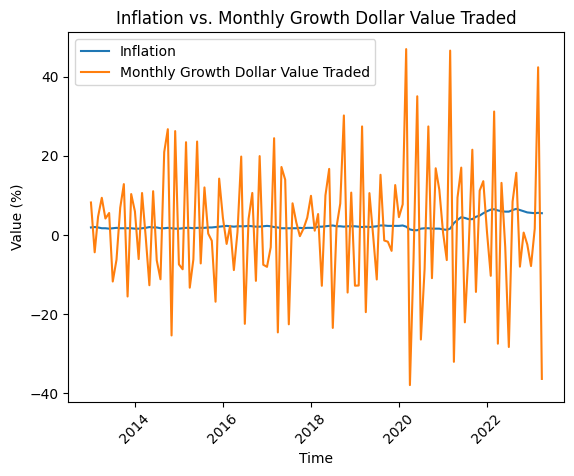

In [ ]:
nyse_inflation["Monthly Growth Dollar Value Traded"] = nyse_inflation["Monthly Growth Dollar Value Traded"] * 100
print(nyse_inflation["Monthly Growth Dollar Value Traded"])

filtered_data = nyse_inflation.dropna(subset=["Inflation"])
#plot
plt.plot(filtered_data["Month"], filtered_data["Inflation"], label="Inflation")
plt.plot(filtered_data["Month"], filtered_data["Monthly Growth Dollar Value Traded"], label="Monthly Growth Dollar Value Traded")
plt.xlabel("Time")
plt.ylabel("Value (%)")
plt.title("Inflation vs. Monthly Growth Dollar Value Traded")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
#we found better inflation data on Compustat, so we are gonna replace it, abd add 1 treasury bonds returns
treasury_inflation = pd.read_excel("Treasury and inflation.xlsx")
print(treasury_inflation.head())

       caldt     b1ret     b1ind    cpiret  cpiind
0 2007-01-31  0.003995  1103.626  0.003053   476.3
1 2007-02-28  0.005063  1109.214  0.005350   478.8
2 2007-03-30  0.003904  1113.544  0.009106   483.2
3 2007-04-30  0.003403  1117.334  0.006496   486.3
4 2007-05-31  0.002538  1120.170  0.006111   489.3


In [ ]:
treasury_inflation = treasury_inflation[['caldt', 'b1ret', 'cpiret']]
print(treasury_inflation.head())

       caldt     b1ret    cpiret
0 2007-01-31  0.003995  0.003053
1 2007-02-28  0.005063  0.005350
2 2007-03-30  0.003904  0.009106
3 2007-04-30  0.003403  0.006496
4 2007-05-31  0.002538  0.006111


In [ ]:
#Data for b1ret and cpiret from the end of last month will be matched to the current month
treasury_inflation['caldt'] = pd.to_datetime(treasury_inflation['caldt']) + pd.offsets.MonthBegin(1)
print(treasury_inflation.head())

       caldt     b1ret    cpiret
0 2007-02-01  0.003995  0.003053
1 2007-03-01  0.005063  0.005350
2 2007-04-01  0.003904  0.009106
3 2007-05-01  0.003403  0.006496
4 2007-06-01  0.002538  0.006111


In [ ]:
treasury_inflation = treasury_inflation.rename(columns={'caldt': 'Month', 'b1ret': '1y_bond_return', 'cpiret': 'mon_inflation'})
print(treasury_inflation.head())


       Month  1y_bond_return  mon_inflation
0 2007-02-01        0.003995       0.003053
1 2007-03-01        0.005063       0.005350
2 2007-04-01        0.003904       0.009106
3 2007-05-01        0.003403       0.006496
4 2007-06-01        0.002538       0.006111


In [ ]:
#times 100 so it is in %
treasury_inflation['1y_bond_return'] = treasury_inflation['1y_bond_return'] * 100
treasury_inflation['mon_inflation'] = treasury_inflation['mon_inflation'] * 100
print(treasury_inflation.head())

       Month  1y_bond_return  mon_inflation
0 2007-02-01          0.3995         0.3053
1 2007-03-01          0.5063         0.5350
2 2007-04-01          0.3904         0.9106
3 2007-05-01          0.3403         0.6496
4 2007-06-01          0.2538         0.6111


In [ ]:
#Save and download the data
treasury_inflation.to_excel("Bonds and inflation.xlsx", index=False)
files.download("/content/Bonds and inflation.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Adding the GDP, done by Semir on another file

#Download the GDP dataset
df_gdp = pd.read_excel("US-Monthly-GDP-History-Data.xlsx", sheet_name="Data")

#From Nominal GDP calculate GDP Growth (in %)
growth = []
for i in range(len(df_gdp)):
  if i == 0:
    growth.append("No Val")
  else:
    growth.append(((df_gdp.iloc[i,1]/df_gdp.iloc[i-1,1])-1)*100)

df_gdp['Monthly Nominal GDP Growth'] = growth
print(df_gdp)

#2 Values missing (04/2023 onwards)...exlude them from the whole dataset?

#Save and download the data
nyse_gdp.to_excel("nyse_gdp.xlsx", index=False)
files.download("/content/nyse_gdp.xlsx")

In [ ]:
#Re-initializing the data
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files

main_df = pd.read_excel("nyse_gdp.xlsx")
print(main_df)

    Market Participant      Month  Dollar Value Traded  \
0             NYSE (N) 2011-02-01         6.105946e+11   
1             NYSE (N) 2011-03-01         7.527405e+11   
2             NYSE (N) 2011-04-01         5.791401e+11   
3             NYSE (N) 2011-05-01         6.776794e+11   
4             NYSE (N) 2011-06-01         7.309292e+11   
..                 ...        ...                  ...   
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Monthly Growth Dollar Value Traded  Inflation  Monthly Nominal GDP Growth  
0                             -0.060316        NaN                    0.160979  
1                              0.232799        NaN                    1.522931  
2                             -0.230625        NaN          

In [ ]:
main_df = main_df.rename(columns={'Monthly Nominal GDP Growth': 'real_gdp_growth'})
print(main_df)

    Market Participant      Month  Dollar Value Traded  \
0             NYSE (N) 2011-02-01         6.105946e+11   
1             NYSE (N) 2011-03-01         7.527405e+11   
2             NYSE (N) 2011-04-01         5.791401e+11   
3             NYSE (N) 2011-05-01         6.776794e+11   
4             NYSE (N) 2011-06-01         7.309292e+11   
..                 ...        ...                  ...   
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Monthly Growth Dollar Value Traded  Inflation  real_gdp_growth  
0                             -0.060316        NaN         0.160979  
1                              0.232799        NaN         1.522931  
2                             -0.230625        NaN         0.448997  
3                      

In [ ]:
#make it time series
main_df['Month'] = pd.to_datetime(main_df['Month'])
main_df.set_index('Month', inplace=True)
print(main_df.head())


           Market Participant  Dollar Value Traded  \
Month                                                
2011-02-01           NYSE (N)         6.105946e+11   
2011-03-01           NYSE (N)         7.527405e+11   
2011-04-01           NYSE (N)         5.791401e+11   
2011-05-01           NYSE (N)         6.776794e+11   
2011-06-01           NYSE (N)         7.309292e+11   

            Monthly Growth Dollar Value Traded  Inflation  real_gdp_growth  
Month                                                                       
2011-02-01                           -0.060316        NaN         0.160979  
2011-03-01                            0.232799        NaN         1.522931  
2011-04-01                           -0.230625        NaN         0.448997  
2011-05-01                            0.170148        NaN        -0.112904  
2011-06-01                            0.078577        NaN        -0.292610  


In [ ]:
#adding 1y treasy yields and new inflation data
treasury_inflation = pd.read_excel("Bonds and inflation.xlsx")
treasury_inflation.set_index('Month', inplace=True)
treasury_inflation.index = pd.to_datetime(treasury_inflation.index)

# Print the updated DataFrame
print(treasury_inflation.head())

            1y_bond_return  mon_inflation
Month                                    
2007-02-01          0.3995         0.3053
2007-03-01          0.5063         0.5350
2007-04-01          0.3904         0.9106
2007-05-01          0.3403         0.6496
2007-06-01          0.2538         0.6111


In [ ]:
#merge and drop old inflation data
main_df = main_df.merge(treasury_inflation, left_index=True, right_index=True, how='left')
#re-run, inflation already droped
main_df = main_df.drop('Inflation', axis=1)
main_df = main_df.rename(columns={'Monthly Growth Dollar Value Traded': 'mon_trad_vol_g'})
print(main_df.head())


           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2011-02-01           NYSE (N)         6.105946e+11       -0.060316   
2011-03-01           NYSE (N)         7.527405e+11        0.232799   
2011-04-01           NYSE (N)         5.791401e+11       -0.230625   
2011-05-01           NYSE (N)         6.776794e+11        0.170148   
2011-06-01           NYSE (N)         7.309292e+11        0.078577   

            real_gdp_growth  1y_bond_return  mon_inflation  
Month                                                       
2011-02-01         0.160979          0.1078         0.4763  
2011-03-01         1.522931          0.0241         0.4931  
2011-04-01         0.448997          0.0077         0.9751  
2011-05-01        -0.112904          0.0672         0.6439  
2011-06-01        -0.292610          0.1021         0.4704  


In [ ]:
main_df.to_excel("checkpoint1.xlsx", index=False)
files.download("/content/checkpoint1.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#adding S&P data
sp500 = pd.read_excel("S&P500.xlsx")
print(sp500.head())

   gvkeyx  epsx12    prccm   datadate              conm
0       3   83.10  1438.24 2007-01-31  S&P 500 Comp-Ltd
1       3   83.10  1406.82 2007-02-28  S&P 500 Comp-Ltd
2       3   84.78  1420.86 2007-03-31  S&P 500 Comp-Ltd
3       3   84.78  1482.37 2007-04-30  S&P 500 Comp-Ltd
4       3   84.78  1530.62 2007-05-31  S&P 500 Comp-Ltd


In [ ]:
sp500 = sp500.drop('gvkeyx', axis = 1)
sp500 = sp500.drop('conm', axis = 1)
print(sp500.head())

   epsx12    prccm   datadate
0   83.10  1438.24 2007-01-31
1   83.10  1406.82 2007-02-28
2   84.78  1420.86 2007-03-31
3   84.78  1482.37 2007-04-30
4   84.78  1530.62 2007-05-31


In [ ]:
sp500['datadate'] = pd.to_datetime(sp500['datadate'])
sp500['datadate'] = sp500['datadate'] + pd.offsets.MonthBegin(1)
sp500.set_index('datadate', inplace=True)
sp500.index = pd.to_datetime(sp500.index)
print(sp500.head())

            epsx12    prccm
datadate                   
2007-02-01   83.10  1438.24
2007-03-01   83.10  1406.82
2007-04-01   84.78  1420.86
2007-05-01   84.78  1482.37
2007-06-01   84.78  1530.62


In [ ]:
sp500 = sp500.rename(columns={'epsx12': 'EPS', 'prccm': 'price_clo'})
print(sp500.head())


              EPS  price_clo
datadate                    
2007-02-01  83.10    1438.24
2007-03-01  83.10    1406.82
2007-04-01  84.78    1420.86
2007-05-01  84.78    1482.37
2007-06-01  84.78    1530.62


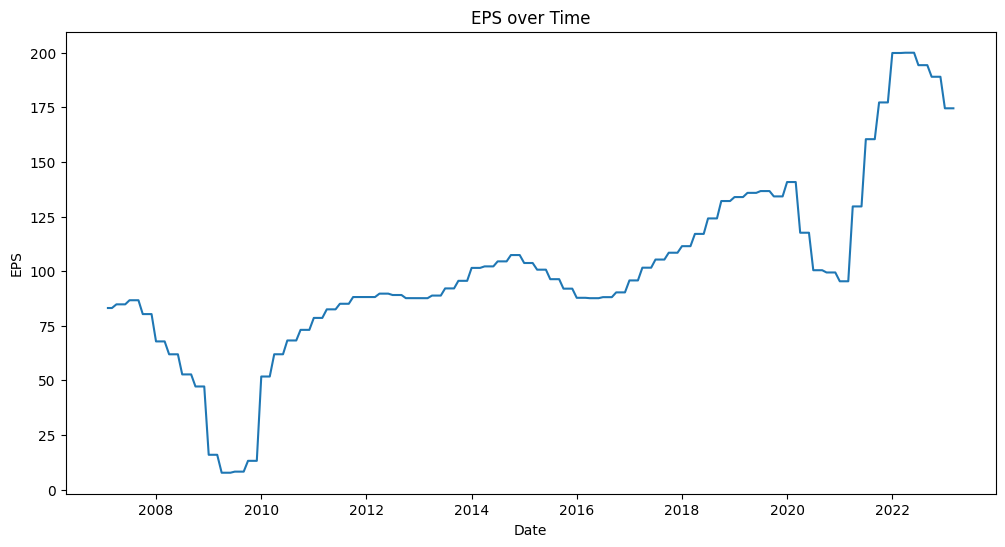

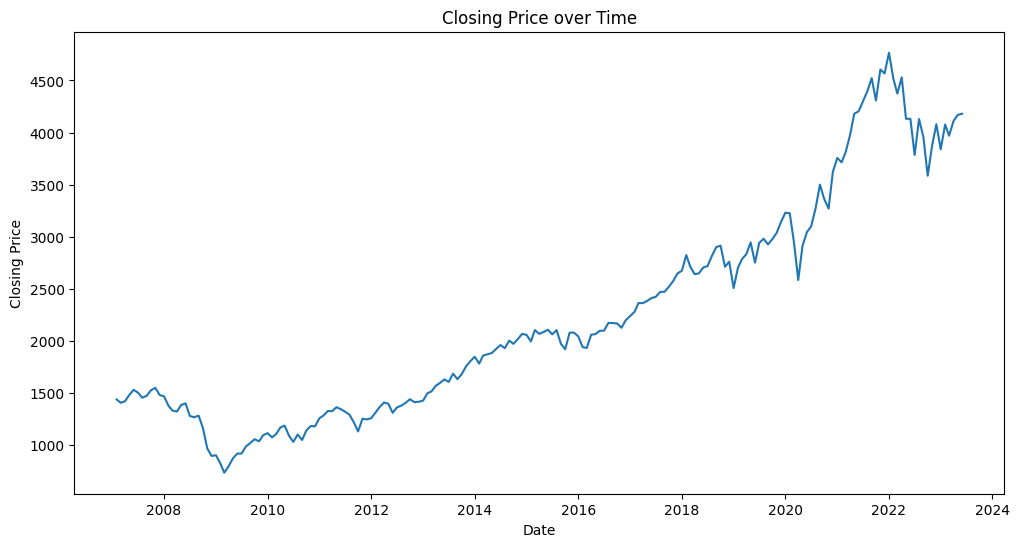

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500['EPS'])
plt.title('EPS over Time')
plt.xlabel('Date')
plt.ylabel('EPS')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500['price_clo'])
plt.title('Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
#dickey-fuller tests
from statsmodels.tsa.stattools import adfuller

eps_values = sp500['EPS']
price_clo_values = sp500['price_clo']

eps_values = eps_values.replace([np.inf, -np.inf], np.nan).dropna()
price_clo_values = price_clo_values.replace([np.inf, -np.inf], np.nan).dropna()


result_eps = adfuller(eps_values)
result_price_clo = adfuller(price_clo_values)


print('Dickey-Fuller Test Results for EPS:')
print(f'Test Statistic: {result_eps[0]}')
print(f'p-value: {result_eps[1]}')
print('Critical Values:')
for key, value in result_eps[4].items():
    print(f'{key}: {value}')

print('Dickey-Fuller Test Results for Closing Price:')
print(f'Test Statistic: {result_price_clo[0]}')
print(f'p-value: {result_price_clo[1]}')
print('Critical Values:')
for key, value in result_price_clo[4].items():
    print(f'{key}: {value}')

Dickey-Fuller Test Results for EPS:
Test Statistic: -0.7032577661437834
p-value: 0.8459038974336681
Critical Values:
1%: -3.467631519151906
5%: -2.8779183721695567
10%: -2.575501353364474
Dickey-Fuller Test Results for Closing Price:
Test Statistic: 1.3135651348169837
p-value: 0.9966838184366011
Critical Values:
1%: -3.4668001583460613
5%: -2.8775552336674317
10%: -2.5753075498128246


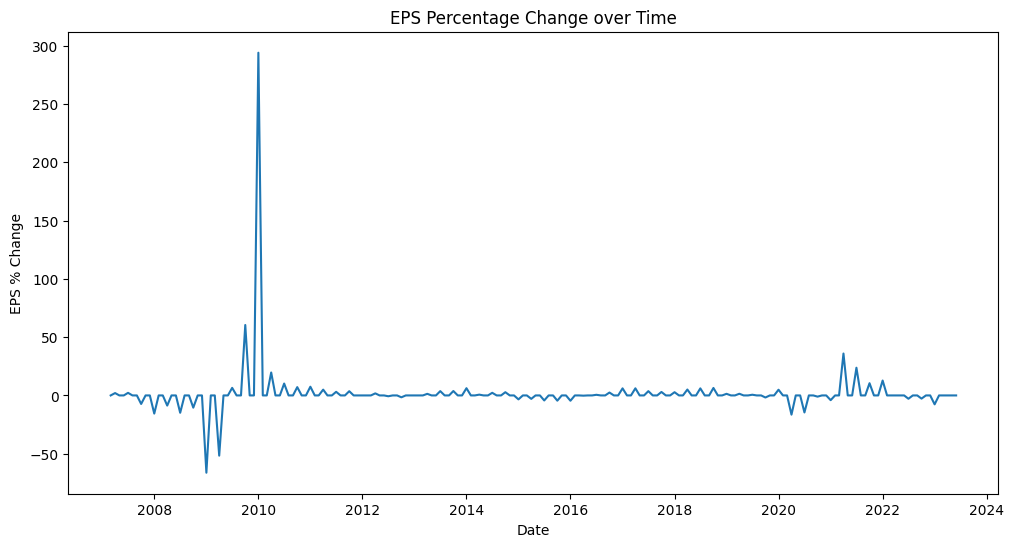

Dickey-Fuller Test Results for EPS Percentage Change:
Test Statistic: -5.898125352596901
p-value: 2.8196006343929906e-07
Critical Values:
1%: -3.4646940755442612
5%: -2.8766348847254934
10%: -2.5748163958763994


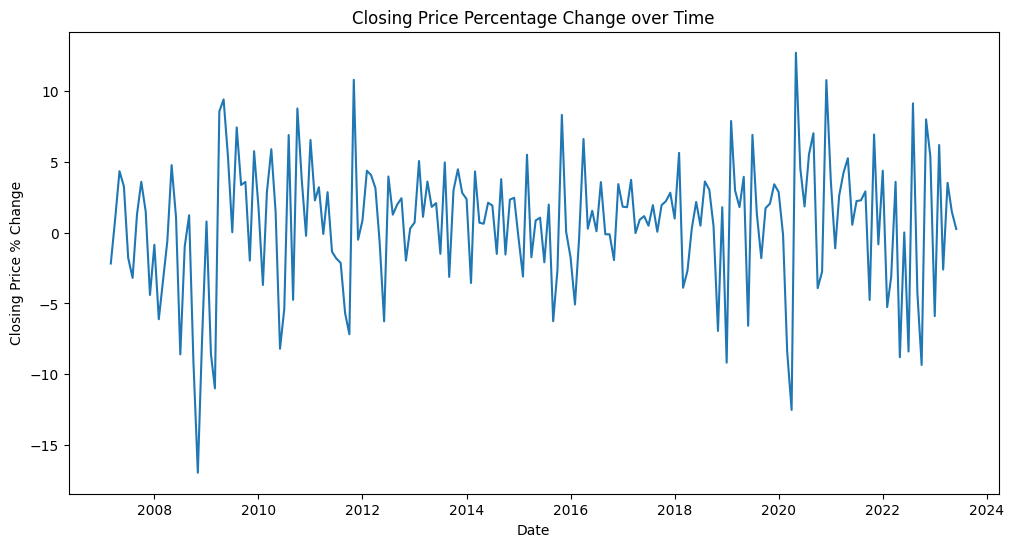

Dickey-Fuller Test Results for Closing Price Percentage Change:
Test Statistic: -5.780083993954196
p-value: 5.150124543314263e-07
Critical Values:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612


In [ ]:
#both non-stationary, use their growth instead

sp500['EPS_pct_change'] = sp500['EPS'].pct_change() * 100
sp500['price_clo_pct_change'] = sp500['price_clo'].pct_change() * 100


plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500['EPS_pct_change'])
plt.title('EPS Percentage Change over Time')
plt.xlabel('Date')
plt.ylabel('EPS % Change')
plt.show()

# DF eps %
result_eps_pct_change = adfuller(sp500['EPS_pct_change'].dropna())
print('Dickey-Fuller Test Results for EPS Percentage Change:')
print(f'Test Statistic: {result_eps_pct_change[0]}')
print(f'p-value: {result_eps_pct_change[1]}')
print('Critical Values:')
for key, value in result_eps_pct_change[4].items():
    print(f'{key}: {value}')

plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500['price_clo_pct_change'])
plt.title('Closing Price Percentage Change over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price % Change')
plt.show()

# DF price_clo in %
result_price_clo_pct_change = adfuller(sp500['price_clo_pct_change'].dropna())
print('Dickey-Fuller Test Results for Closing Price Percentage Change:')
print(f'Test Statistic: {result_price_clo_pct_change[0]}')
print(f'p-value: {result_price_clo_pct_change[1]}')
print('Critical Values:')
for key, value in result_price_clo_pct_change[4].items():
    print(f'{key}: {value}')

**PROBLEM:** EPS IS IN quarterly
IDEA: instead of using EPS, using a dummy for the earnings season, when EPS data is updated and thus its change is different than 0 (End of each quarter)


In [ ]:
#both are now stationary. Add to main_df
#PROBLEM: EPS IS IN QUARTERS -> DROP

sp500['EPS_pct_change_dummy'] = sp500['EPS_pct_change'].apply(lambda x: 1 if x != 0 else 0)
sp500.drop(['EPS', 'EPS_pct_change'], axis=1, inplace=True)
print(sp500.head())

            price_clo  price_clo_pct_change  EPS_pct_change_dummy
datadate                                                         
2007-02-01    1438.24                   NaN                     1
2007-03-01    1406.82             -2.184615                     0
2007-04-01    1420.86              0.997995                     1
2007-05-01    1482.37              4.329068                     0
2007-06-01    1530.62              3.254923                     0


In [ ]:

print(sp500)

            price_clo  price_clo_pct_change  EPS_pct_change_dummy
datadate                                                         
2007-02-01    1438.24                   NaN                     1
2007-03-01    1406.82             -2.184615                     0
2007-04-01    1420.86              0.997995                     1
2007-05-01    1482.37              4.329068                     0
2007-06-01    1530.62              3.254923                     0
...               ...                   ...                   ...
2023-02-01    4076.60              6.175283                     0
2023-03-01    3970.15             -2.611245                     0
2023-04-01    4109.31              3.505157                     0
2023-05-01    4169.48              1.464236                     0
2023-06-01    4179.83              0.248232                     0

[197 rows x 3 columns]


In [ ]:
#I struggled a lot with the dates here. I managed to fix it earlier in the code
#sp500['datadate'] = pd.to_datetime(sp500['datadate'])
#sp500['datadate'] = sp500['datadate'] - pd.DateOffset(months=1)
#sp500['datadate'] = sp500['datadate'].dt.strftime('%Y-%m')
#print(sp500.head())





TypeError: ignored

In [ ]:
sp500.to_excel('sp500_data.xlsx', index=True)
files.download('sp500_data.xlsx')

**NOTE**: Inflation is the inflation of the last month. The same is true for bond returns.
I'll fix that now, but we will prob still use lagged inflation since inflation for the month is only known ex post

In [7]:
#Add price_clo, price_clo_pct_change and EPS_pct_change_dummy to main_dr
# Merge columns from sp500 into main_df
merged_main_df = main_df.merge(sp500[['price_clo', 'price_clo_pct_change', 'EPS_pct_change_dummy']], left_index=True, right_index=True, how='left')
print(merged_main_df)

NameError: ignored

In [ ]:
#fixing bond and inflation
merged_main_df['1y_bond_return'] = merged_main_df['1y_bond_return'].shift(-1)
merged_main_df['mon_inflation'] = merged_main_df['mon_inflation'].shift(-1)

print(merged_main_df.head())



           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2011-02-01           NYSE (N)         6.105946e+11       -0.060316   
2011-03-01           NYSE (N)         7.527405e+11        0.232799   
2011-04-01           NYSE (N)         5.791401e+11       -0.230625   
2011-05-01           NYSE (N)         6.776794e+11        0.170148   
2011-06-01           NYSE (N)         7.309292e+11        0.078577   

            real_gdp_growth  1y_bond_return  mon_inflation  price_clo  \
Month                                                                   
2011-02-01         0.160979          0.0241         0.4931    1286.12   
2011-03-01         1.522931          0.0077         0.9751    1327.22   
2011-04-01         0.448997          0.0672         0.6439    1325.83   
2011-05-01        -0.112904          0.1021         0.4704    1363.61   
2011-06-01        -0.292610          0.0198        -0.1071    1345.20  

In [ ]:
merged_main_df["mon_trad_vol_g"] = merged_main_df["mon_trad_vol_g"] * 100
print(merged_main_df.tail(12))

           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2022-06-01           NYSE (N)         1.306600e+12       -3.024899   
2022-07-01           NYSE (N)         9.366052e+11      -28.317400   
2022-08-01           NYSE (N)         1.015563e+12        8.430177   
2022-09-01           NYSE (N)         1.175228e+12       15.721896   
2022-10-01           NYSE (N)         1.081154e+12       -8.004771   
2022-11-01           NYSE (N)         1.087724e+12        0.607705   
2022-12-01           NYSE (N)         1.061636e+12       -2.398456   
2023-01-01           NYSE (N)         9.782948e+11       -7.850232   
2023-02-01           NYSE (N)         9.939717e+11        1.602481   
2023-03-01           NYSE (N)         1.415257e+12       42.383994   
2023-04-01           NYSE (N)         9.003488e+11      -36.382647   
2023-05-01           NYSE (N)         1.133465e+12       25.891780   

            real_gd

In [6]:
merged_main_df.to_excel('checkpoint_final_data.xlsx', index=False)


NameError: ignored

In [5]:

merged_main_df[['real_gdp_growth', '1y_bond_return', 'mon_inflation', 'mon_trad_vol_g', 'price_clo_pct_change']].plot(figsize=(10, 6))
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Time Series Plot')
plt.legend(loc='upper left')
plt.show()


NameError: ignored

In [ ]:
#Dickey-Fuller test for all. No non-stationarity under my watch
columns = ['real_gdp_growth', '1y_bond_return', 'mon_inflation', 'mon_trad_vol_g', 'price_clo_pct_change']

results = []

for col in columns:
    result = adfuller(merged_main_df[col].dropna())
    test_statistic = result[0]
    critical_value_5p = result[4]['5%']
    results.append((col, test_statistic, critical_value_5p))

for result in results:
    print(f"Column: {result[0]}")
    print(f"Test Statistic: {result[1]}")
    print(f"5% Critical Value: {result[2]}")
    print()


Column: real_gdp_growth
Test Statistic: -10.763015118916478
5% Critical Value: -2.8818291230495543

Column: 1y_bond_return
Test Statistic: -2.659728734883263
5% Critical Value: -2.882721765644168

Column: mon_inflation
Test Statistic: -1.411362539371677
5% Critical Value: -2.8836966192225284

Column: mon_trad_vol_g
Test Statistic: -2.9142371442671875
5% Critical Value: -2.8830370378332995

Column: price_clo_pct_change
Test Statistic: -10.48171068927487
5% Critical Value: -2.881548071241103



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files
from statsmodels.tsa.stattools import adfuller

df = pd.read_excel("checkpoint_final_data.xlsx")
print(df.head())
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

  Market Participant  Dollar Value Traded  mon_trad_vol_g  real_gdp_growth  \
0           NYSE (N)         6.105946e+11       -0.060316         0.160979   
1           NYSE (N)         7.527405e+11        0.232799         1.522931   
2           NYSE (N)         5.791401e+11       -0.230625         0.448997   
3           NYSE (N)         6.776794e+11        0.170148        -0.112904   
4           NYSE (N)         7.309292e+11        0.078577        -0.292610   

   1y_bond_return  mon_inflation  price_clo  price_clo_pct_change  \
0          0.0241         0.4931    1286.12              2.264559   
1          0.0077         0.9751    1327.22              3.195658   
2          0.0672         0.6439    1325.83             -0.104730   
3          0.1021         0.4704    1363.61              2.849536   
4          0.0198        -0.1071    1345.20             -1.350093   

   EPS_pct_change_dummy      Month  
0                     0 2011-02-01  
1                     0 2011-03-01  
2    

In [ ]:
df["inf_pct_change"] = df["mon_inflation"].pct_change() * 100
df["1y_bond_retur_pct_change"] = df["1y_bond_return"].pct_change() * 100

columns = ['inf_pct_change', '1y_bond_retur_pct_change']

results = []

for col in columns:
    result = adfuller(df[col].dropna())
    test_statistic = result[0]
    critical_value_5p = result[4]['5%']
    results.append((col, test_statistic, critical_value_5p))

for result in results:
    print(f"Column: {result[0]}")
    print(f"Test Statistic: {result[1]}")
    print(f"5% Critical Value: {result[2]}")
    print()

Column: inf_pct_change
Test Statistic: -12.033962465262645
5% Critical Value: -2.881548071241103

Column: 1y_bond_retur_pct_change
Test Statistic: -12.110162542681616
5% Critical Value: -2.881548071241103



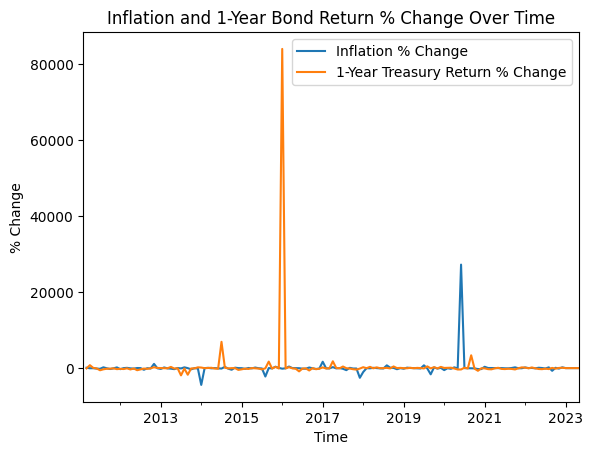

In [ ]:
df['inf_pct_change'].plot(label='Inflation % Change')
df['1y_bond_retur_pct_change'].plot(label='1-Year Treasury Return % Change')

plt.legend()
plt.xlabel('Time')
plt.ylabel('% Change')
plt.title('Inflation and 1-Year Bond Return % Change Over Time')
plt.show()


In [ ]:
max_observation = df['1y_bond_retur_pct_change'].idxmax()
print(df.loc[max_observation])

Market Participant                     NYSE (N)
Dollar Value Traded         740337622576.005493
mon_trad_vol_g                         0.043444
real_gdp_growth                        0.273931
1y_bond_return                           0.2525
mon_inflation                            0.1653
price_clo                               2043.94
price_clo_pct_change                   -1.75302
EPS_pct_change_dummy                          1
inf_pct_change                      -148.375768
1y_bond_retur_pct_change           84066.666667
Name: 2016-01-01 00:00:00, dtype: object


In [ ]:
df = df.drop(['1y_bond_retur_pct_change', 'inf_pct_change'], axis=1)


**FINDING THE "TYPICAL MONTHS": CLUSTERING**

In [ ]:
df = pd.read_excel("checkpoint_final_data - Copia.xlsx")
print(df.head())
print(df.tail())
df['mon_trad_vol_g'] = df['mon_trad_vol_g'] * 100

  Market Participant  Dollar Value Traded  mon_trad_vol_g  real_gdp_growth  \
0           NYSE (N)         6.105946e+11       -0.060316         0.160979   
1           NYSE (N)         7.527405e+11        0.232799         1.522931   
2           NYSE (N)         5.791401e+11       -0.230625         0.448997   
3           NYSE (N)         6.776794e+11        0.170148        -0.112904   
4           NYSE (N)         7.309292e+11        0.078577        -0.292610   

   1y_bond_return  mon_inflation  price_clo  price_clo_pct_change  \
0          0.0241         0.4931    1286.12              2.264559   
1          0.0077         0.9751    1327.22              3.195658   
2          0.0672         0.6439    1325.83             -0.104730   
3          0.1021         0.4704    1363.61              2.849536   
4          0.0198        -0.1071    1345.20             -1.350093   

   EPS_pct_change_dummy  
0                     0  
1                     0  
2                     1  
3           

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)
#data_for_clustering['ID'] = range(len(data_for_clustering))
#data_for_clustering.set_index('ID', inplace=True)

In [ ]:
# import KMeans class
from sklearn.cluster import KMeans

columns_for_clustering = ['mon_trad_vol_g', 'real_gdp_growth', '1y_bond_return', 'mon_inflation', 'price_clo_pct_change', 'EPS_pct_change_dummy']
data_for_clustering = df[columns_for_clustering]


kmeans = KMeans(n_clusters=10)
# fit model
kmeans.fit(data_for_clustering)
y_preds = kmeans.predict(data_for_clustering)
df["cluster_kmeans"] = y_preds



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(df.head())

  Market Participant  Dollar Value Traded  mon_trad_vol_g  real_gdp_growth  \
0           NYSE (N)         6.105946e+11       -6.031550         0.160979   
1           NYSE (N)         7.527405e+11       23.279927         1.522931   
2           NYSE (N)         5.791401e+11      -23.062452         0.448997   
3           NYSE (N)         6.776794e+11       17.014765        -0.112904   
4           NYSE (N)         7.309292e+11        7.857667        -0.292610   

   1y_bond_return  mon_inflation  price_clo  price_clo_pct_change  \
0          0.0241         0.4931    1286.12              2.264559   
1          0.0077         0.9751    1327.22              3.195658   
2          0.0672         0.6439    1325.83             -0.104730   
3          0.1021         0.4704    1363.61              2.849536   
4          0.0198        -0.1071    1345.20             -1.350093   

   EPS_pct_change_dummy  cluster_kmeans  
0                     0               0  
1                     0         

In [ ]:
cluster_avg = df.groupby('cluster_kmeans')[columns_for_clustering].mean()
print(cluster_avg)


                mon_trad_vol_g  real_gdp_growth  1y_bond_return  \
cluster_kmeans                                                    
0                    -4.588205         0.279360        0.030250   
1                    26.280139         0.921583        0.015192   
2                   -31.449679        -3.782253        0.019000   
3                    10.049290         0.446378        0.085138   
4                   -24.471156         0.398506        0.048236   
5                    52.275261        -0.399721        0.398333   
6                   -11.887292         0.684806        0.038025   
7                   -11.573534         0.827983        0.035230   
8                    16.078516         0.231378        0.045307   
9                     2.841831         0.483432        0.064984   

                mon_inflation  price_clo_pct_change  EPS_pct_change_dummy  
cluster_kmeans                                                             
0                    0.224319              

<ipython-input-45-d78e452ae627>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_avg = df.groupby('cluster_kmeans')['mon_trad_vol_g', 'price_clo_pct_change'].mean()


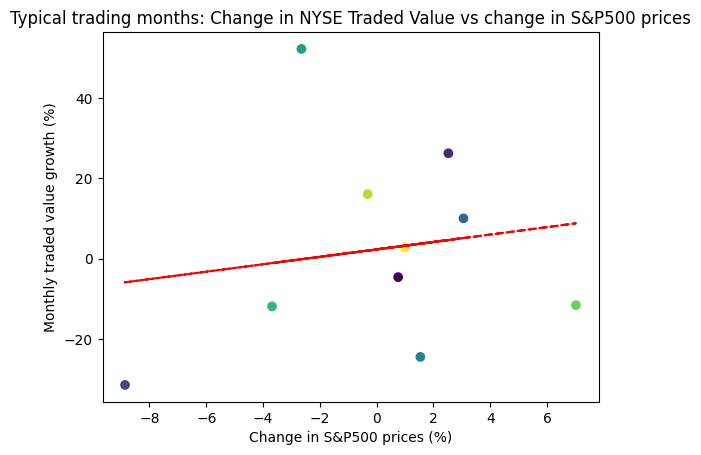

In [ ]:
cluster_avg = df.groupby('cluster_kmeans')['mon_trad_vol_g', 'price_clo_pct_change'].mean()

x = cluster_avg['price_clo_pct_change']
y = cluster_avg['mon_trad_vol_g']
coefficients = np.polyfit(x, y, 1)
best_fit_line = np.polyval(coefficients, x)

plt.scatter(cluster_avg['price_clo_pct_change'], cluster_avg['mon_trad_vol_g'], c=cluster_avg.index)
plt.plot(x, best_fit_line, color='red', linestyle='--')
plt.xlabel('Change in S&P500 prices (%)')
plt.ylabel('Monthly traded value growth (%)')
plt.title('Typical trading months: Change in NYSE Traded Value vs change in S&P500 prices')
plt.show()


<ipython-input-47-51becfc517a6>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_avg = df.groupby('cluster_kmeans')[column, 'mon_trad_vol_g'].mean()
<ipython-input-47-51becfc517a6>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_avg = df.groupby('cluster_kmeans')[column, 'mon_trad_vol_g'].mean()
<ipython-input-47-51becfc517a6>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_avg = df.groupby('cluster_kmeans')[column, 'mon_trad_vol_g'].mean()
<ipython-input-47-51becfc517a6>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_avg = df.groupby('cluster_kmeans')[column, 'mon_trad_vol_g'].mean()


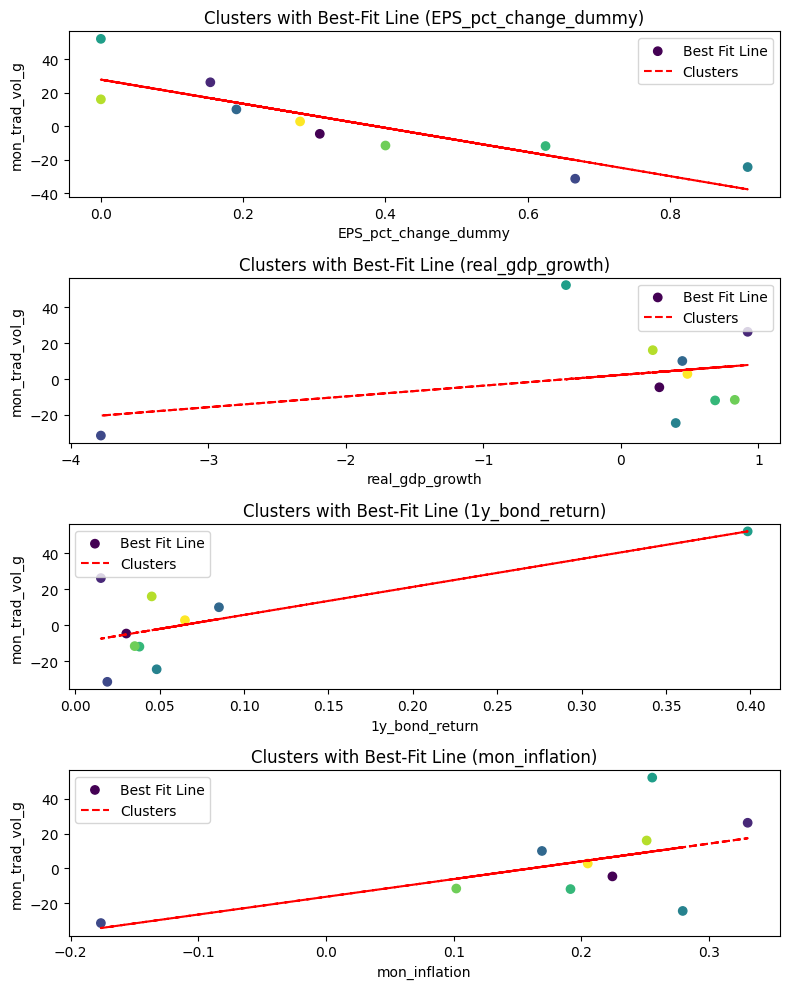

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


columns_for_clustering = ['EPS_pct_change_dummy', 'real_gdp_growth', '1y_bond_return', 'mon_inflation']


fig, axs = plt.subplots(len(columns_for_clustering), 1, figsize=(8, 10))


for i, column in enumerate(columns_for_clustering):

    cluster_avg = df.groupby('cluster_kmeans')[column, 'mon_trad_vol_g'].mean()


    x = cluster_avg[column].values.reshape(-1)
    y = cluster_avg['mon_trad_vol_g']
    coefficients = np.polyfit(x, y, 1)
    best_fit_line = np.polyval(coefficients, x)


    axs[i].scatter(x, y, c=cluster_avg.index)
    axs[i].plot(x, best_fit_line, color='red', linestyle='--')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('mon_trad_vol_g')
    axs[i].set_title(f'Clusters with Best-Fit Line ({column})')
    axs[i].legend(['Best Fit Line', 'Clusters'])

plt.tight_layout()
plt.show()


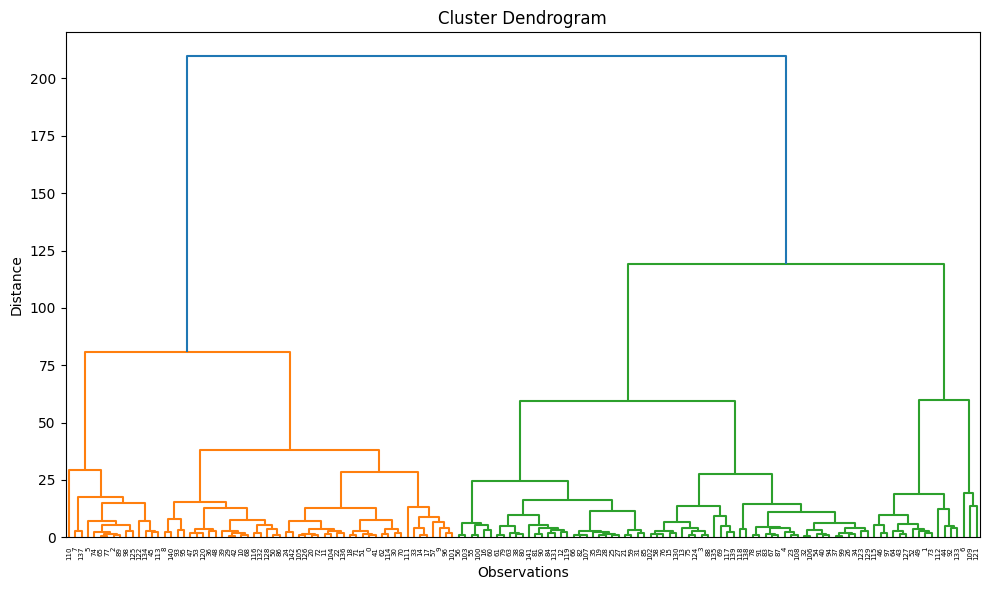

In [ ]:
from scipy.cluster import hierarchy

columns_for_clustering = ['price_clo_pct_change', 'real_gdp_growth', '1y_bond_return', 'mon_inflation', 'mon_trad_vol_g']
data_for_clustering = df[columns_for_clustering]
linkage = hierarchy.linkage(data_for_clustering, method='ward')

plt.figure(figsize=(10, 6))
hierarchy.dendrogram(linkage, labels=df.index, leaf_rotation=90)
plt.title('Cluster Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [ ]:
#RE-DOING WITH 4 CLUSTERS
df.drop('cluster_kmeans', axis=1, inplace=True)
columns_for_clustering = ['mon_trad_vol_g', 'real_gdp_growth', '1y_bond_return', 'mon_inflation', 'price_clo_pct_change', 'EPS_pct_change_dummy']
data_for_clustering = df[columns_for_clustering]


kmeans = KMeans(n_clusters=4)
# fit model
kmeans.fit(data_for_clustering)
y_preds = kmeans.predict(data_for_clustering)
df["cluster_kmeans"] = y_preds

cluster_avg = df.groupby('cluster_kmeans')[columns_for_clustering].mean()
print(cluster_avg)

                mon_trad_vol_g  real_gdp_growth  1y_bond_return  \
cluster_kmeans                                                    
0                    -5.715542         0.537476        0.045076   
1                    10.921209         0.335810        0.065494   
2                   -23.303652        -0.214583        0.024958   
3                    32.569559         0.749175        0.096107   

                mon_inflation  price_clo_pct_change  EPS_pct_change_dummy  
cluster_kmeans                                                             
0                    0.210019              0.826870              0.406780  
1                    0.198984              1.450281              0.137255  
2                    0.142821             -0.549557              0.736842  
3                    0.336614              1.300530              0.142857  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**RECURRENT NEURAL NETWORK (RRNs)**
To predict NYSE value traded growth

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files
from statsmodels.tsa.stattools import adfuller

new_df = pd.read_excel("checkpoint_final_data.xlsx")
new_df['mon_trad_vol_g'] = new_df['mon_trad_vol_g'] * 100
print(new_df.head())
print(new_df.tail(10))

  Market Participant  Dollar Value Traded  mon_trad_vol_g  real_gdp_growth  \
0           NYSE (N)         6.105946e+11       -6.031550         0.160979   
1           NYSE (N)         7.527405e+11       23.279927         1.522931   
2           NYSE (N)         5.791401e+11      -23.062452         0.448997   
3           NYSE (N)         6.776794e+11       17.014765        -0.112904   
4           NYSE (N)         7.309292e+11        7.857667        -0.292610   

   1y_bond_return  mon_inflation  price_clo  price_clo_pct_change  \
0          0.0241         0.4931    1286.12              2.264559   
1          0.0077         0.9751    1327.22              3.195658   
2          0.0672         0.6439    1325.83             -0.104730   
3          0.1021         0.4704    1363.61              2.849536   
4          0.0198        -0.1071    1345.20             -1.350093   

   EPS_pct_change_dummy      Month  
0                     0 2011-02-01  
1                     0 2011-03-01  
2    

In [13]:
new_df['Month'] = pd.to_datetime(new_df['Month'])
new_df.set_index('Month', inplace=True)

new_df = new_df[new_df.index.year < 2023]

print(new_df.head())
print(new_df.tail())

           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2011-02-01           NYSE (N)         6.105946e+11       -6.031550   
2011-03-01           NYSE (N)         7.527405e+11       23.279927   
2011-04-01           NYSE (N)         5.791401e+11      -23.062452   
2011-05-01           NYSE (N)         6.776794e+11       17.014765   
2011-06-01           NYSE (N)         7.309292e+11        7.857667   

            real_gdp_growth  1y_bond_return  mon_inflation  price_clo  \
Month                                                                   
2011-02-01         0.160979          0.0241         0.4931    1286.12   
2011-03-01         1.522931          0.0077         0.9751    1327.22   
2011-04-01         0.448997          0.0672         0.6439    1325.83   
2011-05-01        -0.112904          0.1021         0.4704    1363.61   
2011-06-01        -0.292610          0.0198        -0.1071    1345.20  

In [14]:
start_date = '2011-02-01'
end_date = '2022-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='M')
num_months = len(date_range)

print(num_months)

143


In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

columns = ['mon_trad_vol_g', 'real_gdp_growth', '1y_bond_return', 'mon_inflation', 'price_clo_pct_change', 'EPS_pct_change_dummy']
time_series_data = new_df[columns].values.astype(float)


In [16]:
time_series = np.array(time_series_data).reshape(-1,6)
scaler = MinMaxScaler(feature_range=(0, 1))
time_series = scaler.fit_transform(time_series)

In [17]:
train_data = time_series[:131]  # First 131 months for training
test_data = time_series[131:]   # Last 12 months for testing

In [18]:
print(train_data[0])
print(train_data.shape)

[0.31538881 0.64124028 0.36103719 0.56886843 0.58645381 0.        ]
(131, 6)


In [49]:
#def create_X_sequences(data, seq_length):
 #   X = []
  #  for i in range(len(data) - seq_length):
   #     X.append(data[i:i+seq_length])
   # return np.array(X)

def create_Y_sequences(data, seq_length):
    Y = data[seq_length:]
    return np.array(Y)



def create_X_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
    return np.array(X)

sequence_length = 6

X_train = create_X_sequences(train_data, seq_length=sequence_length)
y_train = create_Y_sequences(train_data[:, -1], seq_length=sequence_length)
X_test = create_X_sequences(test_data, seq_length=sequence_length)
y_test = create_Y_sequences(test_data[:, -1], seq_length=sequence_length)



In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(125, 6, 6)
(125,)
(6, 6, 6)
(6,)


In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

print(X_train.shape)

(125, 6, 6)


In [22]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.LSTM(units=25, input_shape=(sequence_length, 6), return_sequences=True),
    keras.layers.LSTM(units=25),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 7s 360ms/step - loss: 0.3411 - val_loss: 0.2903
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 0.2904 - val_loss: 0.2536
Epoch 3/100
4/4 [==============================] - 0s 23ms/step - loss: 0.2549 - val_loss: 0.2267
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.2287 - val_loss: 0.2151
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.2186 - val_loss: 0.2172
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2179 - val_loss: 0.2242
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2232 - val_loss: 0.2232
Epoch 8/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2199 - val_loss: 0.2129
Epoch 9/100
4/4 [==============================] - 0s 22ms/step - loss: 0.2123 - val_loss: 0.2090
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.2126 - val_loss: 0.2081
Epoch 11/100
4/4 [

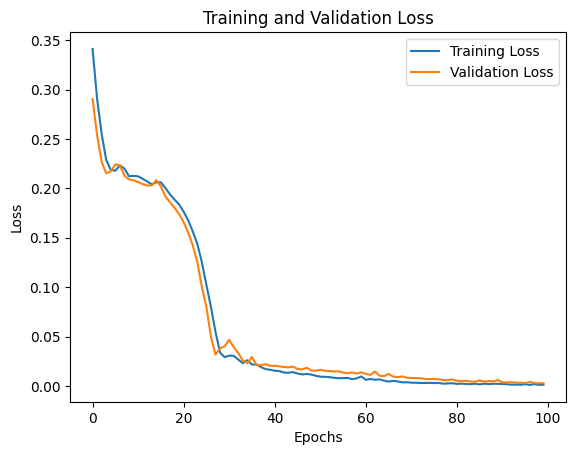

In [23]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
#I will train again, now with only 15 epochs. And add regularization to stop over fitting
from tensorflow.keras import regularizers

model = keras.Sequential([
    keras.layers.LSTM(units=25, input_shape=(sequence_length, 5), return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=25, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#MUCH BETTER. I'm gonna increase epochs again
from tensorflow.keras import regularizers

model = keras.Sequential([
    keras.layers.LSTM(units=25, input_shape=(sequence_length, 5), return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=25, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

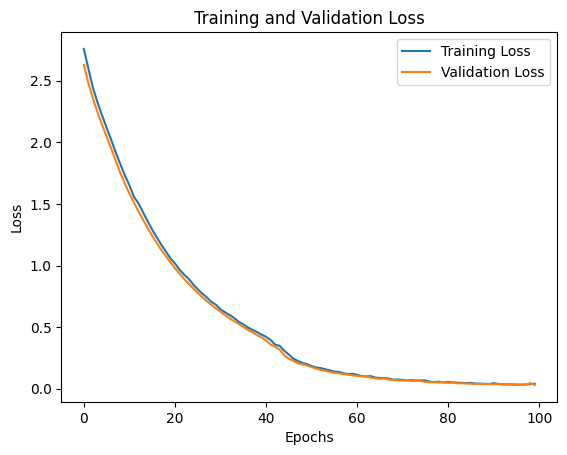

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#MUCH BETTER. I'm gonna increase epochs again
from tensorflow.keras import regularizers

model = keras.Sequential([
    keras.layers.LSTM(units=25, input_shape=(sequence_length, 5), return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=25, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


ValueError: ignored

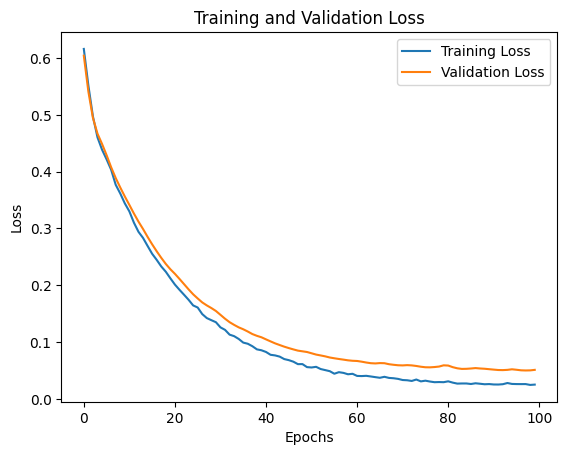

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
4/4 [==============================] - 6s 338ms/step - loss: 2.7582 - val_loss: 2.6278
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 2.5981 - val_loss: 2.4814
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 2.4435 - val_loss: 2.3555
Epoch 4/100
4/4 [==============================] - 0s 23ms/step - loss: 2.3247 - val_loss: 2.2445
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 2.2195 - val_loss: 2.1437
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 2.1186 - val_loss: 2.0466
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 2.0222 - val_loss: 1.9503
Epoch 8/100
4/4 [==============================] - 0s 23ms/step - loss: 1.9181 - val_loss: 1.8513
Epoch 9/100
4/4 [==============================] - 0s 22ms/step - loss: 1.8254 - val_loss: 1.7533
Epoch 10/100
4/4 [==============================] - 0s 23ms/step - loss: 1.7323 - val_loss: 1.6657
Epoch 11/100
4/4 [

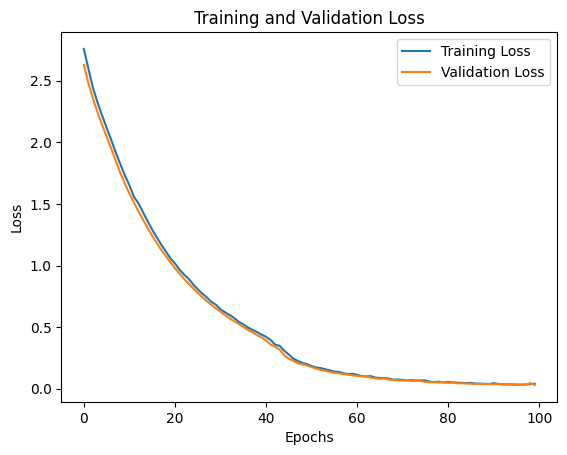

In [31]:
#Looks like 100 epochs is good, but Im gonna increase the regularization penalty to decrease overfitting. From 0.01 to 0.05.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

reg_penalty = 0.05
model = keras.Sequential([
    keras.layers.LSTM(units=25, input_shape=(sequence_length, 6), return_sequences=True, kernel_regularizer=regularizers.l2(reg_penalty)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=25, kernel_regularizer=regularizers.l2(reg_penalty)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
#MUCH BETTER. This is the model that I will use from now on.

#MAKE PREDICTIONS:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)





1/1 [==============================] - 0s 24ms/step


In [33]:
train_preds = train_preds.reshape(-1, 1)
test_preds = test_preds.reshape(-1, 1)

output_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler.fit(time_series_data[:, 0].reshape(-1, 1))
test_preds = output_scaler.inverse_transform(test_preds)
train_preds = output_scaler.inverse_transform(train_preds)




In [34]:
import matplotlib.pyplot as plt
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train_inverted = output_scaler.inverse_transform(y_train)
y_test_inverted = output_scaler.inverse_transform(y_test)


In [35]:
#I was having problem aligning the data here, so I did it on excel
import pandas as pd

df_y_train = pd.DataFrame({'y_train_inverted': y_train_inverted.flatten()})
df_y_train.to_excel('y_train_inverted.xlsx', index=False)


df_y_test = pd.DataFrame({'y_test_inverted': y_test_inverted.flatten()})
df_y_test.to_excel('y_test_inverted.xlsx', index=False)


df_train_preds = pd.DataFrame({'train_preds': train_preds.flatten()})
df_train_preds.to_excel('train_preds.xlsx', index=False)


df_test_preds = pd.DataFrame({'test_preds': test_preds.flatten()})
df_test_preds.to_excel('test_preds.xlsx', index=False)


In [36]:
test_prediction = pd.read_excel("Test_Predictions.xlsx")

print(test_prediction)

FileNotFoundError: ignored

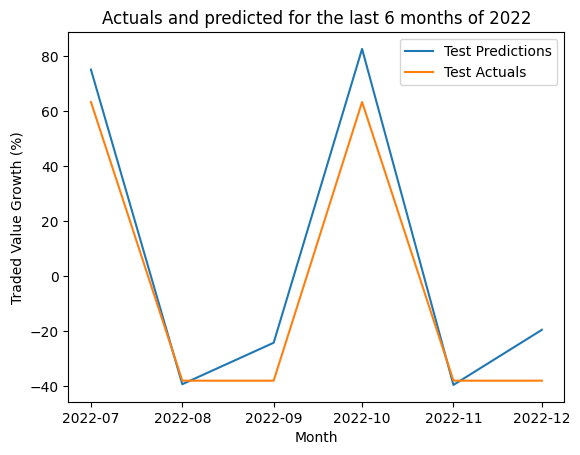

In [ ]:

plt.plot(test_prediction['Month'], test_prediction['test_preds'], label='Test Predictions')
plt.plot(test_prediction['Month'], test_prediction['y_test_inverted'], label='Test Actuals')

plt.xlabel('Month')
plt.ylabel('Traded Value Growth (%)')
plt.title('Actuals and predicted for the last 6 months of 2022')
plt.legend()
plt.show()




In [ ]:
train_prediction = pd.read_excel("Train_Predictions.xlsx")

print(train_prediction)

         Month  y_train_inverted  train_preds
0   2011-08-01        -37.945678   -41.581429
1   2011-09-01        -37.945678   -27.655161
2   2011-10-01         63.244112    78.745514
3   2011-11-01        -37.945678   -42.069229
4   2011-12-01        -37.945678   -22.538332
..         ...               ...          ...
120 2021-08-01        -37.945678   -41.607964
121 2021-09-01        -37.945678   -31.679169
122 2021-10-01         63.244112    76.610306
123 2021-11-01        -37.945678   -42.867512
124 2021-12-01        -37.945678   -25.406616

[125 rows x 3 columns]


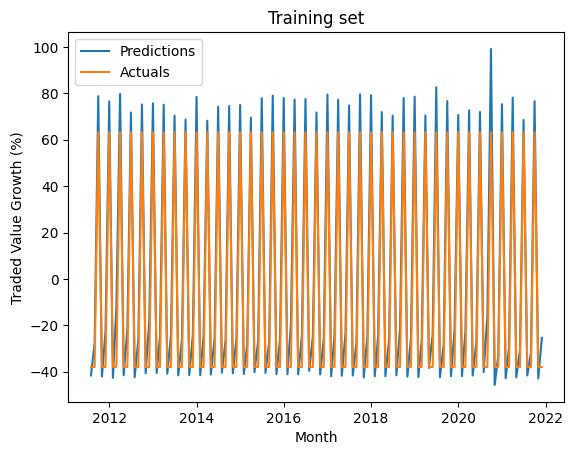

In [ ]:
plt.plot(train_prediction['Month'], train_prediction['train_preds'], label='Predictions')
plt.plot(train_prediction['Month'], train_prediction['y_train_inverted'], label='Actuals')
plt.xlabel('Month')
plt.ylabel('Traded Value Growth (%)')
plt.title('Training set')
plt.legend()
plt.show()

In [37]:
import matplotlib.pyplot as plt
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train_inverted = output_scaler.inverse_transform(y_train)
y_test_inverted = output_scaler.inverse_transform(y_test)

#preds = np.concatenate((train_preds, test_preds))
#actual = np.concatenate((y_train_inverted, y_test_inverted))

#time_index = range(len(preds))


#plt.figure(figsize=(10, 6))
#plt.plot(time_index, actual, label='Actual')
#plt.plot(time_index, preds, label='Model')
#plt.xlabel('Time')
#plt.ylabel('Traded Value growth (%)')
#plt.title('Model vs Actual')
#plt.legend()
#plt.show()





In [38]:
from sklearn.metrics import mean_squared_error


train_mse = mean_squared_error(y_train_inverted, train_preds)
test_mse = mean_squared_error(y_test_inverted, test_preds)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)


Train MSE: 60.356587920657084
Test MSE: 104.8374330497118


In [39]:

final_df = pd.read_excel("checkpoint_final_data.xlsx")
final_df['mon_trad_vol_g'] = final_df['mon_trad_vol_g'] * 100
final_df.set_index('Month', inplace=True)
print(final_df)
print(final_df.columns)

           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2011-02-01           NYSE (N)         6.105946e+11       -6.031550   
2011-03-01           NYSE (N)         7.527405e+11       23.279927   
2011-04-01           NYSE (N)         5.791401e+11      -23.062452   
2011-05-01           NYSE (N)         6.776794e+11       17.014765   
2011-06-01           NYSE (N)         7.309292e+11        7.857667   
...                       ...                  ...             ...   
2023-01-01           NYSE (N)         9.782948e+11       -7.850232   
2023-02-01           NYSE (N)         9.939717e+11        1.602481   
2023-03-01           NYSE (N)         1.415257e+12       42.383994   
2023-04-01           NYSE (N)         9.003488e+11      -36.382647   
2023-05-01           NYSE (N)         1.133465e+12       25.891780   

            real_gdp_growth  1y_bond_return  mon_inflation  price_clo  \
Month           

In [40]:
final_df = final_df[~final_df.index.year.isin([2023])]
print(final_df.tail())

           Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                                
2022-08-01           NYSE (N)         1.015563e+12        8.430177   
2022-09-01           NYSE (N)         1.175228e+12       15.721896   
2022-10-01           NYSE (N)         1.081154e+12       -8.004771   
2022-11-01           NYSE (N)         1.087724e+12        0.607705   
2022-12-01           NYSE (N)         1.061636e+12       -2.398456   

            real_gdp_growth  1y_bond_return  mon_inflation  price_clo  \
Month                                                                   
2022-08-01         1.620371         -0.2666        -0.0354    4130.29   
2022-09-01        -0.286581         -0.4026         0.2151    3955.00   
2022-10-01         0.838964          0.1372         0.4056    3585.62   
2022-11-01         0.778018          0.2016        -0.1010    3871.98   
2022-12-01        -0.293671          0.4019        -0.3070    4080.11  

In [41]:
import pandas as pd

# Convert the index of final_df to PeriodIndex with frequency 'M'
final_df.index = pd.PeriodIndex(final_df.index, freq='M')

# Select the last 6 months of 2022 in final_df
final_df_last_6_months_2022 = final_df.loc['2022-07':'2022-12']

# Add the 'Test Predictions' column to final_df_last_6_months_2022
final_df_last_6_months_2022['Test Predictions'] = test_preds.flatten()

# Update final_df with the modified final_df_last_6_months_2022
final_df.update(final_df_last_6_months_2022)

# Print the updated final_df
print(final_df.tail())


        Market Participant  Dollar Value Traded  mon_trad_vol_g  \
Month                                                             
2022-08           NYSE (N)         1.015563e+12        8.430177   
2022-09           NYSE (N)         1.175228e+12       15.721896   
2022-10           NYSE (N)         1.081154e+12       -8.004771   
2022-11           NYSE (N)         1.087724e+12        0.607705   
2022-12           NYSE (N)         1.061636e+12       -2.398456   

         real_gdp_growth  1y_bond_return  mon_inflation  price_clo  \
Month                                                                
2022-08         1.620371         -0.2666        -0.0354    4130.29   
2022-09        -0.286581         -0.4026         0.2151    3955.00   
2022-10         0.838964          0.1372         0.4056    3585.62   
2022-11         0.778018          0.2016        -0.1010    3871.98   
2022-12        -0.293671          0.4019        -0.3070    4080.11   

         price_clo_pct_change  EPS_pct_

<ipython-input-41-47aa0fe3da7c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_last_6_months_2022['Test Predictions'] = test_preds.flatten()


In [42]:
print(len(train_preds))
print(len(actual))
print(len(test_preds))

125


NameError: ignored

In [43]:
#DID NOT WORK
predictions_df = []
result_df = []
# Create a DataFrame for the predictions and actual values
predictions_df = pd.DataFrame({
    'Predictions': np.concatenate((train_preds, test_preds)).flatten(),
    'Actuals': np.concatenate((y_train_inverted, y_test_inverted)).flatten()
})

# Get the corresponding months and Dollar Value Traded from new_df
months = final_df['Month']
dollar_value_traded = final_df['Dollar Value Traded']

# Filter months and dollar_value_traded for the desired time periods
filtered_months = months[(months.dt.year == 2022) & (months.dt.month >= 7)]  # Last six months of 2022
filtered_dollar_value_traded = dollar_value_traded[(months.dt.year == 2022) & (months.dt.month >= 7)]

# Create an index for the train_preds and test_preds arrays
train_index = pd.date_range(start='2011-02-01', end='2022-01-01', freq='M')[:-6]  # Exclude last 6 months
test_index = pd.date_range(start='2022-06-01', end='2022-12-01', freq='M')

train_index = pd.period_range(start='2011-08', end='2021-12', freq='M')
test_index = pd.period_range(start='2022-07', end='2022-12', freq='M')

train_preds_df = pd.DataFrame({'Train Predictions': train_preds.flatten()}, index=train_index)
test_preds_df = pd.DataFrame({'Test Predictions': test_preds.flatten()}, index=test_index)

# Concatenate the predictions DataFrames with filtered months and Dollar Value Traded
result_df = pd.concat([train_preds_df, test_preds_df, filtered_months, filtered_dollar_value_traded, predictions_df], axis=1)

# Print the result DataFrame
print(result_df.head())
print(result_df.tail())



KeyError: ignored

In [93]:
obs=[]
for i in range(0,len(final_df)):
  row=[]
  row.append(final_df.iloc[i,3])
  row.append(final_df.iloc[i,4])
  row.append(final_df.iloc[i,5])
  row.append(final_df.iloc[i,7])
  row.append(final_df.iloc[i,8])
  obs.append(row)
print(obs)

[[0.1609785523208673, 0.0241, 0.4931, 2.264559015298473, 0.0], [1.522930632071584, 0.0077, 0.9751, 3.195658258949408, 0.0], [0.4489967406511086, 0.0672, 0.6439, -0.1047301879115836, 1.0], [-0.1129037204675498, 0.1021, 0.4704, 2.849535762503486, 0.0], [-0.2926104768946058, 0.0198, -0.1071, -1.350092768460176, 0.0], [0.6092267178221533, -0.0921, 0.0886, -1.825750817722271, 1.0], [0.6405983307059993, 0.1945, 0.2758, -2.147443663678228, 0.0], [-0.6656684897404119, -0.1243, 0.1518, -5.679109790447878, 0.0], [1.577288751754935, 0.065, -0.2063, -7.176201297902196, 1.0], [-0.1214617851865718, 0.0291, -0.0844, 10.77230383058456, 0.0], [-0.04564101745575533, -0.0495, -0.2467, -0.5058645176733378, 0.0], [0.6924940136821434, 0.045, 0.44, 0.8532751652017501, 1.0], [1.680173737157897, -0.0635, 0.4403, 4.358301526717567, 0.0], [-0.9325910200197796, -0.0285, 0.7595000000000001, 4.058944994323421, 0.0], [0.7607929506769473, 0.0716, 0.3021, 3.133237654501775, 1.0], [0.2530534543017993, 0.0108, -0.1173, 

In [94]:
ok=round(len(obs)*0.8) #80% of data will be used to train the data with the 20% used to test it
x_train=obs[:ok] # all data points until 80% point
x_test=obs[ok:]#all data points after the 80% line


In [95]:
y=[]

for i in range(0,len(final_df)):
  y.append(final_df.iloc[i,2])

ye=round(len(y)*0.8)
Y_train=y[:ok]
Y_test=y[ok:]

In [96]:
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()  # create the logistic regression object
modelLR = modelLR.fit(x_train, Y_train)  # fit on trainings data

pred_y_train = modelLR.predict(x_train)
pred_y_test = modelLR.predict(x_test)

In [97]:
train_mse = mean_squared_error(Y_train, pred_y_train)
test_mse = mean_squared_error(Y_test, pred_y_test)

In [98]:
print("Training MSE:", train_mse)
print("Testing MSE: ", test_mse)

Training MSE: 183.1842915665174
Testing MSE:  296.30104223926463


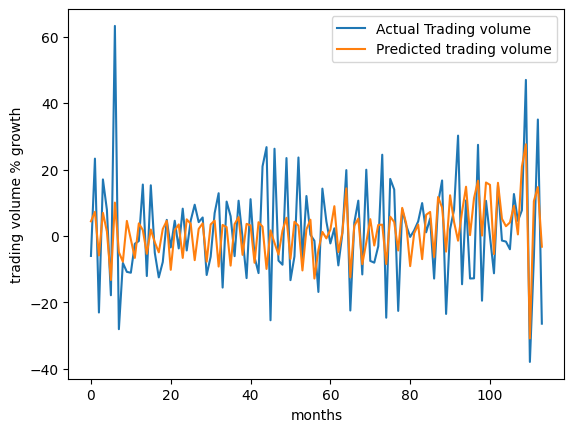

In [99]:
plt.plot(Y_train, label='Actual Trading volume')
plt.plot(pred_y_train, label='Predicted trading volume')

plt.xlabel('months')
plt.ylabel('trading volume % growth')
plt.legend()
plt.show()

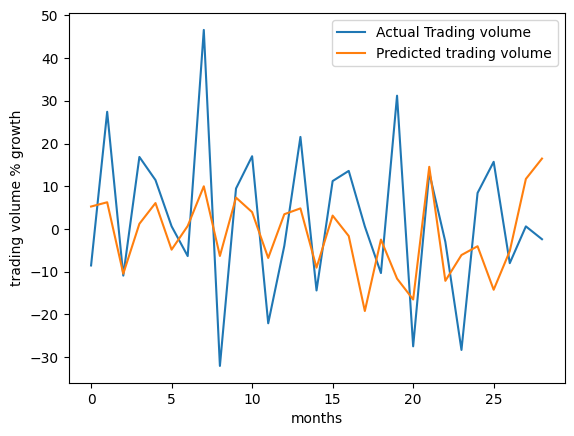

In [100]:
plt.plot(Y_test, label='Actual Trading volume')
plt.plot(pred_y_test, label='Predicted trading volume')

plt.xlabel('months')
plt.ylabel('trading volume % growth')
plt.legend()
plt.show()